In [1]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, Layer
from tensorflow.keras import Model, Sequential
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os


In [2]:

def gram_matrix(inputs):
    features = K.batch_flatten(K.permute_dimensions(inputs, (0, 2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# generative deep learning pg 159
class GramMatrix(Layer):
    def call(self, inputs):
        #print(inputs.shape)
        #inputs = K.reshape(inputs, shape=(1, *inputs.shape[1:]))
        nchw = K.permute_dimensions(inputs, (0, 3, 1, 2))
        N, C, H, W = nchw.shape
        features = K.reshape(nchw, (N, C, H * W))
        features_T = K.permute_dimensions(features, (0, 2, 1))
        gram = K.dot(features, features_T)
        return gram

keras.utils.get_custom_objects().update({"GramMatrix": GramMatrix})


In [3]:
DATA_FILE = "x.npy"

batch_size = 32

## Load Data
Load data and split it into batches. Split into batches because the model(s) has/have a custom training loop and is trained one batch at a time so splitting the data now makes it a little easier later.

In [4]:
x = np.load(DATA_FILE)
img_shape = x.shape[1:]
x = np.split(x[:len(x)//batch_size * batch_size], len(x)//batch_size)

Keep track of tensors and layers becuase layers are used to define `Sequential` models and tensors are used to define the input and output of `Model` models

In [5]:
encoder_conv_tensors = []
encoder_conv_layers = []

decoder_conv_tensors = []
decoder_conv_layers = []

## Define the Models
Imagine the autoencoder as a U shape, with the top two points in the U being the first layer of the encoder and the last layer of the decoder. The layers are created starting at the top of the U, going down.

In [6]:
input_tensor = Input(shape=img_shape)

num_layers = int(math.log2(img_shape[0])) # All layers have a stride of 2 and the images are preprocessed to be squares with a power of two side length
                                          # so `num_layers` layers will reduce the images down to a 1x1 feature stack
for i in range(num_layers):
    num_encoder_filters = 3*2**(i+1)
    num_decoder_filters = 3*2**i
    if i == 0:
        encoder_layer = Conv2D(num_encoder_filters, 5, strides=2, padding="same", activation='selu')
        encoder_tensor = encoder_layer(input_tensor)
        decoder_layer = Conv2DTranspose(3, 5, strides=2, padding="same", activation='sigmoid')
        decoder_tensor = decoder_layer(encoder_tensor)
    else:
        encoder_layer = Conv2D(num_encoder_filters, 3, strides=2, padding="same", activation='selu')
        encoder_tensor = encoder_layer(encoder_conv_tensors[-1])
        decoder_layer = Conv2DTranspose(num_decoder_filters, 3, strides=2, padding="same", activation='selu')
        decoder_tensor = decoder_layer(encoder_tensor)
    
    encoder_conv_tensors.append(encoder_tensor)
    encoder_conv_layers.append(encoder_layer)

    decoder_conv_tensors.append(decoder_tensor)
    decoder_conv_layers.append(decoder_layer)

decoder_conv_layers.reverse()

encoder = Sequential(encoder_conv_layers)
decoder = Sequential(decoder_conv_layers)

autoencoder = Sequential([encoder, decoder])
autoencoder = keras.models.clone_model(autoencoder)
autoencoder.compile(optimizer="adam", loss="MSE", metrics=["mean_absolute_error"])

hidden_encoders_outputs = [GramMatrix()(t) for t in encoder_conv_tensors[:-1]]
hidden_encoders = Model(inputs=[input_tensor], outputs=hidden_encoders_outputs)

models = []
for i in range(num_layers):
    output_tensor = GramMatrix()(decoder_conv_tensors[i]) if i > 0 else decoder_conv_tensors[i]
    model = Model(inputs=[input_tensor], outputs=[output_tensor])
    for layer in model.layers[:-2]:
        layer.trainable = False
    model.compile(optimizer="adam", loss="MSE", metrics=["mean_absolute_error"])
    models.append(model)
    model.summary()

Tensor("gram_matrix/Reshape:0", shape=(None, None), dtype=float32)
Tensor("gram_matrix_1/Reshape:0", shape=(None, None), dtype=float32)
Tensor("gram_matrix_2/Reshape:0", shape=(None, None), dtype=float32)
Tensor("gram_matrix_3/Reshape:0", shape=(None, None), dtype=float32)
Tensor("gram_matrix_4/Reshape:0", shape=(None, None), dtype=float32)
Tensor("gram_matrix_5/Reshape:0", shape=(None, None), dtype=float32)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 6)         456       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 128, 128, 3)       453       
Total params: 909
Trainable params: 909
Non-trainable params: 0
________________________________________

In [7]:
def train_step(batch):
    targets = [batch]
    hidden_targets = hidden_encoders.predict(batch)
    targets.extend(hidden_targets)

    for i, model in enumerate(models):
        model.train_on_batch(batch, targets[i])
    
    autoencoder.train_on_batch(batch, batch)

epochs = 10
for i in range(epochs):
    print("\nEpoch %d/%d" % (i, epochs))
    for batch in tqdm(x):
        train_step(batch)

  0%|          | 0/413 [00:00<?, ?it/s]
Epoch 0/10
Tensor("functional_1/gram_matrix_5/Reshape:0", shape=(32, 768), dtype=float32)
Tensor("functional_1/gram_matrix_4/Reshape:0", shape=(32, 1536), dtype=float32)
Tensor("functional_1/gram_matrix_3/Reshape:0", shape=(32, 3072), dtype=float32)
Tensor("functional_1/gram_matrix_2/Reshape:0", shape=(32, 6144), dtype=float32)
Tensor("functional_1/gram_matrix_1/Reshape:0", shape=(32, 12288), dtype=float32)
Tensor("functional_1/gram_matrix/Reshape:0", shape=(32, 24576), dtype=float32)
Tensor("functional_5/gram_matrix_6/Reshape:0", shape=(32, 24576), dtype=float32)
Tensor("functional_5/gram_matrix_6/Reshape:0", shape=(32, 24576), dtype=float32)
Tensor("functional_7/gram_matrix_7/Reshape:0", shape=(32, 12288), dtype=float32)
Tensor("functional_7/gram_matrix_7/Reshape:0", shape=(32, 12288), dtype=float32)
Tensor("functional_9/gram_matrix_8/Reshape:0", shape=(32, 6144), dtype=float32)
Tensor("functional_9/gram_matrix_8/Reshape:0", shape=(32, 6144), d

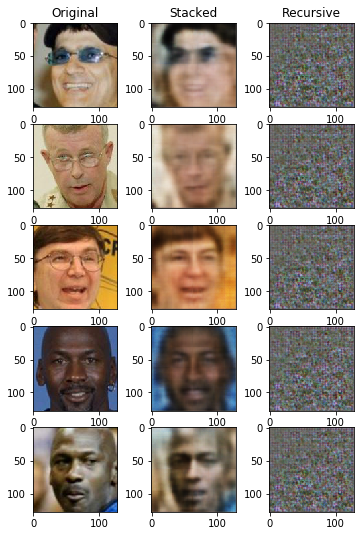

In [8]:
# encoding_depth = 0

display_images = x[0][:10]

encoder = Sequential(encoder_conv_layers)
decoder = Sequential(decoder_conv_layers)

recursive_autoencoder = Sequential([encoder, decoder])

reconstructions = recursive_autoencoder.predict(display_images)
basic_reconstructions = autoencoder.predict(display_images)

fig, axs = plt.subplots(5, 3)

titles = ["Original", "Stacked", "Recursive"]

for r, row in enumerate(axs):
    imgs = [x[0][r], basic_reconstructions[r], reconstructions[r]]
    for c, ax in enumerate(row):
        img = imgs[c].astype(float)
        ax.imshow(img)
        if r == 0:
            ax.set_title(titles[c])

fig.set_size_inches(6, 9)
fig.savefig("stacked_vs_recursive.png")
fig.show()

In [9]:
recursive_autoencoder.save("../models/gram_R_7_384.h5")
autoencoder.save("../models/gram_S_7_384.h5")

OSError: Unable to create file (unable to open file: name = 'models/R_7_384.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)